# Logistic Regression (Juices dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


In [2]:
# import local utility functions and classes
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Load raw data and plot

In [3]:
# init data object
data_obj = Data('../../data/juices/FTIR_juices.csv', 'label', -1)
data = data_obj.data
data.head(5)

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,label
810,0.002280,0.002245,0.002229,0.002344,0.002588,0.002799,0.002843,0.002734,0.002598,0.002512,...,0.000101,0.000058,0.000040,0.000025,0.000020,0.000010,0.000004,0.000005,0.000005,NON-Strawberry
801,0.002533,0.002589,0.002648,0.002809,0.003137,0.003495,0.003698,0.003716,0.003596,0.003425,...,-0.000073,-0.000061,-0.000030,-0.000020,0.000002,-0.000015,-0.000027,-0.000006,-0.000006,NON-Strawberry
813,0.002571,0.002566,0.002538,0.002605,0.002824,0.003011,0.003010,0.002870,0.002727,0.002628,...,0.000034,0.000017,-0.000029,-0.000031,-0.000041,0.000007,0.000035,0.000011,0.000011,NON-Strawberry
497,0.002719,0.002721,0.002732,0.002836,0.003050,0.003296,0.003436,0.003429,0.003346,0.003228,...,0.000237,0.000151,0.000093,0.000062,0.000040,0.000034,0.000027,0.000011,0.000011,NON-Strawberry
67,0.003028,0.003027,0.003052,0.003167,0.003363,0.003592,0.003738,0.003745,0.003638,0.003485,...,0.000192,0.000126,0.000083,0.000052,0.000034,0.000021,0.000010,0.000004,0.000004,Strawberry


NON-Strawberry: blue
Strawberry: red


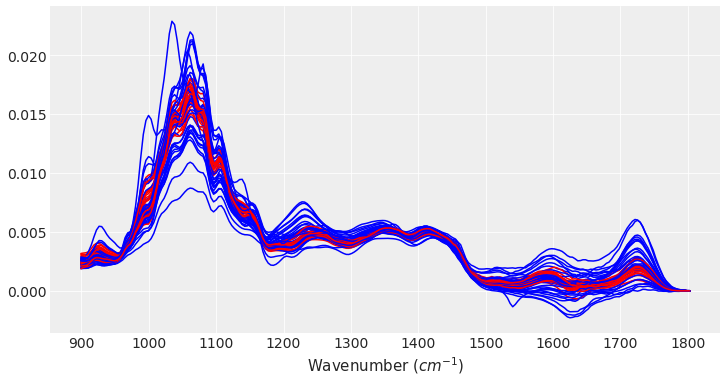

In [4]:
# name of column containing the labels
label_col = data_obj.label_column

# number of non-data columns at right of dataframe
non_data_cols = data_obj.non_data_columns

# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 50)

In [5]:
# number of samples from each class
data[label_col].value_counts()

NON-Strawberry    632
Strawberry        351
Name: label, dtype: int64

In [6]:
# generate training and test sets
train_data, test_data = train_test_split(data, test_size=0.33, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [7]:
test_data.shape

(325, 236)

In [8]:
train_data.shape

(658, 236)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = logistic(\alpha+\beta X) \\
y \sim Bernoulli(\theta)
\end{equation}

In [9]:
# get Y labels and standardize data
Y = pd.Categorical(train_data[label_col]).codes
x_n = train_data.columns[:non_data_cols]
x_s = train_data[x_n].values
x_s = utl.standardize(x_s)

In [10]:
with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 
 
    trace_mlr = pm.sample(2000, init='adapt_diag', random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [1:12:24<00:00,  1.15draws/s]
The acceptance probability does not match the target. It is 0.8789820724934737, but should be close to 0.8. Try to increase the number of tuning steps.


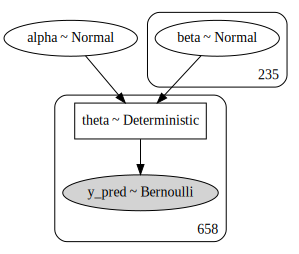

In [11]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [12]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-18.264,2.637,-23.000,-13.246,0.045,0.032,3482.0,3413.0,3515.0,3502.0,1.0
beta[0],-1.254,6.906,-14.044,11.648,0.098,0.111,4959.0,1951.0,4971.0,2948.0,1.0
beta[1],-6.405,7.638,-21.012,7.400,0.115,0.099,4405.0,2962.0,4405.0,2990.0,1.0
beta[2],-2.762,8.266,-18.599,12.615,0.112,0.133,5446.0,1937.0,5489.0,2879.0,1.0
beta[3],-1.482,8.712,-17.356,15.318,0.102,0.143,7310.0,1849.0,7294.0,2961.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[230],-3.536,7.630,-18.082,10.552,0.108,0.108,5033.0,2516.0,5027.0,3085.0,1.0
beta[231],-3.876,6.428,-16.244,7.852,0.107,0.089,3593.0,2587.0,3595.0,3192.0,1.0
beta[232],-10.939,5.676,-22.455,-0.727,0.089,0.068,4044.0,3534.0,4062.0,2960.0,1.0
beta[233],-10.086,4.883,-19.631,-1.310,0.084,0.061,3386.0,3175.0,3383.0,2801.0,1.0


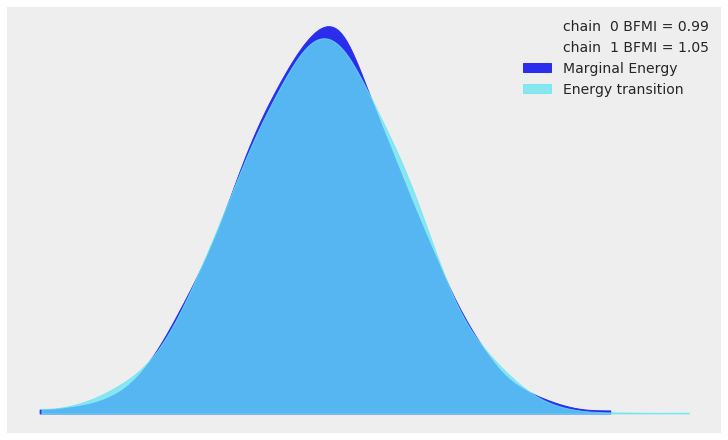

In [13]:
#az.plot_forest(trace_mlr, var_names=varnames, combined=True);
az.plot_energy(trace_mlr, figsize=(10, 6));

In [14]:
# check model predictions on test dataset
utl.display_predictions(data_obj, trace_mlr, test_data)

              label  pred      pred_label
0        Strawberry   1.0      Strawberry
1    NON-Strawberry   0.0  NON-Strawberry
2        Strawberry   1.0      Strawberry
3        Strawberry   1.0      Strawberry
4    NON-Strawberry   0.0  NON-Strawberry
..              ...   ...             ...
320  NON-Strawberry   0.0  NON-Strawberry
321      Strawberry   1.0      Strawberry
322      Strawberry   1.0      Strawberry
323  NON-Strawberry   0.0  NON-Strawberry
324  NON-Strawberry   0.0  NON-Strawberry

[325 rows x 3 columns]


In [15]:
# prediction score on test dataset
utl.logistic_score(data_obj, test_data, test_data.iloc[:,-1])

total  : 325
correct: 325
error  : 0
score  : 100.0%


# Save inference results

In [16]:
pm.backends.text.dump('./traces/trace_juices', trace_mlr)